# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Import the necessary libraries

In [2]:
import tensorflow as tf
import csv
import numpy as np
from PIL import Image

from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

Using TensorFlow backend.


### Change directory

In [0]:
import os
os.chdir('/content/drive/My Drive/GreatlakesAIML/13 Advanced Computer Vision/LAB R9/')

### Load the training data from train.csv file

In [51]:
!pip install patool
import patoolib
patoolib.extract_archive('/content/drive/My Drive/GreatlakesAIML/13 Advanced Computer Vision/LAB R9/images_racoon.rar')

patool: Extracting /content/drive/My Drive/GreatlakesAIML/13 Advanced Computer Vision/LAB R9/images_racoon.rar ...
patool: running /usr/bin/unrar x -- "/content/drive/My Drive/GreatlakesAIML/13 Advanced Computer Vision/LAB R9/images_racoon.rar"
patool:     with cwd='./Unpack_b_nrimxh'
patool: ... /content/drive/My Drive/GreatlakesAIML/13 Advanced Computer Vision/LAB R9/images_racoon.rar extracted to `images_racoon1' (local file exists).


'images_racoon1'

In [0]:
# SETTINGS

ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_SIZE = 128 # MobileNet takes images of size 128*128*3 

EPOCHS = 10 # Number of epochs. I got decent performance with just 5.
BATCH_SIZE = 32 # Depends on your GPU or CPU RAM.

DATASET_FOLDER = "/content/drive/My Drive/GreatlakesAIML/13 Advanced Computer Vision/LAB R9/"
TRAIN_CSV = DATASET_FOLDER+"train_labels.csv"
#VALIDATION_CSV = DATASET_FOLDER+"validation.csv"

#images_zip_path = DATASET_FOLDER + "images.zip"

#from zipfile import ZipFile

#with ZipFile(images_zip_path, 'r') as z:
#  z.extractall()

In [0]:
import csv
with open(TRAIN_CSV, 'r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile)-1, 4))
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(reader)
    for col, row in enumerate(reader):
               
        #for i, r in enumerate(row[1:7]): # Parse row with seven entities
           #row[i-1] = int(r)
           #if col==0:
            # print(col)
             #col=col+1
  
              
        filename, width, height, _, x0, y0, x1, y1 = row  
        path = filename
        coords[col-1, 0] = int(x0) * IMAGE_SIZE / int(height) # Normalize bounding box by image size
        coords[col-1, 1] = int(y0) * IMAGE_SIZE / int(width) # Normalize bounding box by image size
        coords[col-1, 2] = (int(x1) -int(x0)) * IMAGE_SIZE / int(height) # Normalize bounding box by image size
        coords[col-1, 3] = (int(y1) - int(y0)) * IMAGE_SIZE / int(width)
        paths.append(path)

batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
    img = Image.open('/content/drive/My Drive/GreatlakesAIML/13 Advanced Computer Vision/LAB R9/images_racoon/images/' + f) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

### Print the shape of the train dataset

In [67]:
batch_images.shape

(173, 128, 128, 3)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [68]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)












17227776/17225924 [==============================] - 2s 0us/step


### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
gt = coords
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [0]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE

In [75]:
model.fit(batch_images,gt,
            epochs=10,batch_size = 32,
            verbose=1)



Epoch 1/10
173/173 [==============================] - 7s 39ms/step - loss: 3258.5207 - IoU: 0.0857
Epoch 2/10
173/173 [==============================] - 6s 33ms/step - loss: 1018.8279 - IoU: 0.3770
Epoch 3/10
173/173 [==============================] - 6s 33ms/step - loss: 939.4831 - IoU: 0.3943
Epoch 4/10
173/173 [==============================] - 6s 33ms/step - loss: 888.0605 - IoU: 0.4404
Epoch 5/10
173/173 [==============================] - 6s 32ms/step - loss: 657.2410 - IoU: 0.4849
Epoch 6/10
173/173 [==============================] - 6s 33ms/step - loss: 568.0872 - IoU: 0.4940
Epoch 7/10
173/173 [==============================] - 6s 33ms/step - loss: 532.7801 - IoU: 0.5135
Epoch 8/10
173/173 [==============================] - 6s 33ms/step - loss: 471.4560 - IoU: 0.5331
Epoch 9/10
173/173 [==============================] - 6s 33ms/step - loss: 422.7019 - IoU: 0.5513
Epoch 10/10
173/173 [==============================] - 6s 33ms/step - loss: 384.1666 - IoU: 0.5795


### Pick a test image from the given data

In [0]:
import cv2
filename = '/content/drive/My Drive/GreatlakesAIML/13 Advanced Computer Vision/LAB R9/images_racoon/images/raccoon-100.jpg'
unscaled = cv2.imread(filename) # Original image for display

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [0]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

In [0]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

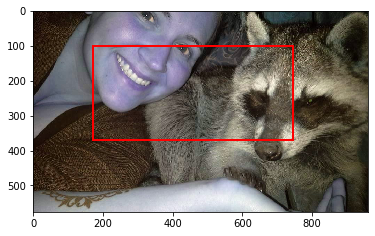

In [80]:
#x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
#y0 = int(region[1] * image_height / IMAGE_SIZE)

#x1 = int((region[2]) * image_width / IMAGE_SIZE)
#y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.utils import np_utils

#### Mount google drive

#### Change your present working directory

### Load your data file

In [82]:
df = pd.read_csv('/content/drive/My Drive/GreatlakesAIML/13 Advanced Computer Vision/LAB R9/daily-minimum-temperatures-in-me.csv')
df.sort_index(inplace=True)
df.tail(4)

,Date,Temperature
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7
3649,1990-12-31,13.0


#### Plot data

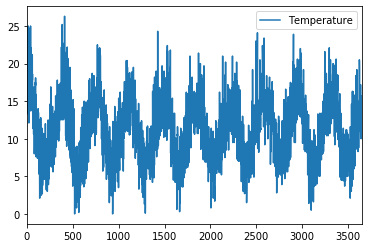

In [86]:
df.plot()

#### Descibe your dataframe

In [89]:
df.describe()

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


#### Check for null values

In [90]:
df.isnull().sum()

Date           0
Temperature    0
dtype: int64

#### Drop null values

In [0]:
#no null values

#### Get the representation of the distribution of data in the form of histogram

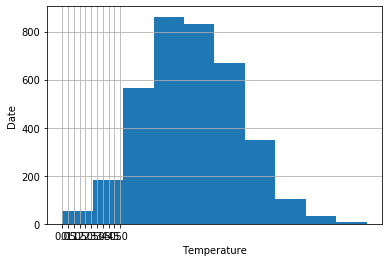

In [91]:
plt.hist(df.Temperature)
plt.xticks([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
plt.xlabel('Temperature')
plt.ylabel('Date')
plt.grid()
plt.show()

#### Check the maximum and minimum values

In [92]:
#Check Data Range
print('Min', np.min(df))
print('Max', np.max(df))

Min Date           1981-01-01
Temperature             0
dtype: object
Max Date           1990-12-31
Temperature          26.3
dtype: object


### Normalize the data

In [0]:
df.drop("Date", axis=1, inplace=True)

In [94]:
df

,Temperature
0,20.7
1,17.9
2,18.8
3,14.6
4,15.8
...,...
3645,14.0
3646,13.6
3647,13.5
3648,15.7


In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
#Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)

#### Check the maximum and minimum values of scaled data

In [97]:
#Check Data Range
print('Min', np.min(df))
print('Max', np.max(df))

Min Temperature    0.0
dtype: float64
Max Temperature    26.3
dtype: float64


#### Look into some of the scaled values

### Split data into Training and Testing

In [0]:

train_size = int(len(scaled) * 0.70)

#30% will be used for Test
test_size = len(scaled - train_size)


In [102]:
#Split the data
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


#### Print train and test size

In [103]:
print(train_size)
print(test_size)

2555
3650


## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
#window - how long the sequence will be
def create_dataset(dataset, window=1):
    
    dataX, dataY = [], []
    
    for i in range(len(dataset)-window):
        
        a = dataset[i:(i+window), 0]        
        dataX.append(a)
        dataY.append(dataset[i + window, 0])
    
    return np.array(dataX), np.array(dataY)

#### Use function to get training and test set

In [0]:
#Create Input and Output
window_size = 1
X_train, y_train = create_dataset(train, window_size)
X_test, y_test = create_dataset(test, window_size)

#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [106]:
#Make it 3 Dimensional Data - needed for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2554, 1, 1)
(1094, 1, 1)


## Define Model

### Define sequntial model, add LSTM layer and compile the model

In [0]:
import tensorflow as tf

In [108]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(32, input_shape=(window_size, 1))) # 1 is there because we have one feature only i.e. one more column i.e the column we created for next month passenger traffic
model.add(tf.keras.layers.Dense(1)) # we have only one output i.e we are predicting next month air passenger traffic
model.compile(optimizer='adam', loss='mse')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Summarize your model

In [109]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [110]:
model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), batch_size=32)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2554 samples, validate on 1094 samples
Epoch 1/200
2554/2554 [==============================] - 1s 455us/sample - loss: 0.0790 - val_loss: 0.0223
Epoch 2/200
2554/2554 [==============================] - 0s 118us/sample - loss: 0.0145 - val_loss: 0.0123
Epoch 3/200
2554/2554 [==============================] - 0s 114us/sample - loss: 0.0131 - val_loss: 0.0115
Epoch 4/200
2554/2554 [==============================] - 0s 124us/sample - loss: 0.0124 - val_loss: 0.0110
Epoch 5/200
2554/2554 [==============================] - 0s 125us/sample - loss: 0.0118 - val_loss: 0.0103
Epoch 6/200
2554/2554 [==============================] - 0s 113us/sample - loss: 0.0112 - val_loss: 0.0099
Epoch 7/200
2554/2554 [==============================] - 0s 123us/sample - loss: 0.0108 - val_loss: 0.0094
Epoch 8/200
2554/2554 [==============================] - 0s 117us/sample - loss: 0.0105 - val_loss: 0.0093
Ep

## Make Predictions and Evaluate your model

In [0]:
#Get prediction for both Training and Test Data
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [112]:
X_test[0]

array([[0.58174905]])

In [0]:
myInput = np.reshape(scaler.transform(pd.DataFrame({"Temperature":[10]})), 1,1)

In [115]:
np.reshape(myInput, (1, 1, 1))

array([[[0.38022814]]])

In [116]:
model.predict(np.reshape(myInput, (1, 1, 1)))

array([[0.3838083]], dtype=float32)

In [118]:
myInput = np.reshape(scaler.transform(pd.DataFrame({"Temperature":[10]})), 1,1)
int(scaler.inverse_transform(model.predict(np.reshape(myInput, (1, 1, 1)))))

10

In [121]:
model.predict(np.reshape(X_test[0], (1, 1, 1)))

array([[0.53492683]], dtype=float32)

In [0]:
#Un-normalize the predited data
trainPredict = model.predict(X_train) 
testPredict = model.predict(X_test)
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

In [0]:
import matplotlib.pyplot as plt

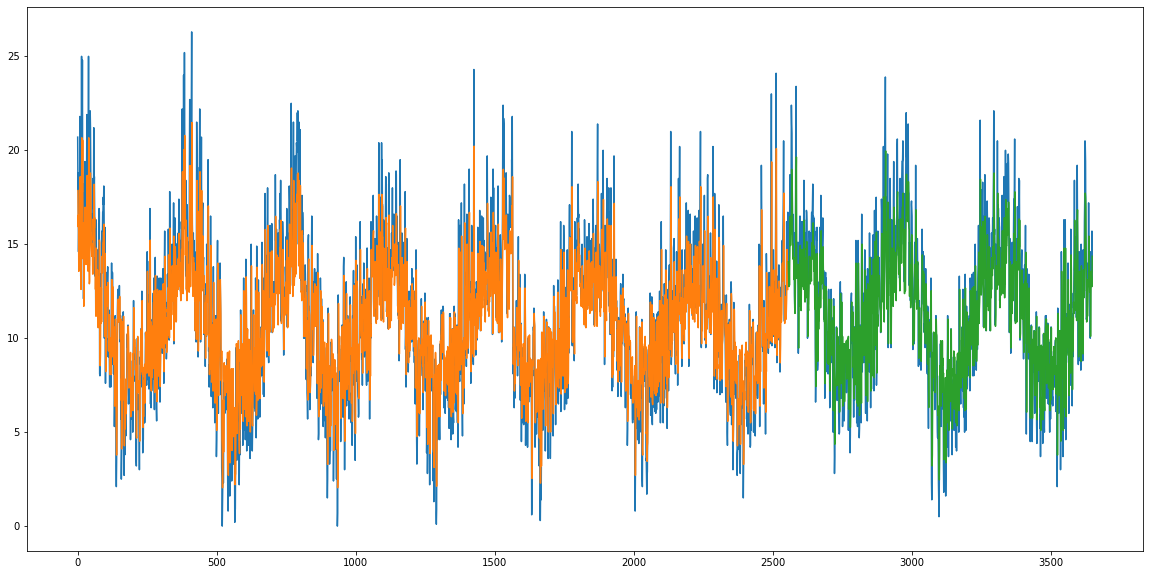

In [125]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window_size:len(trainPredict)+window_size, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(window_size*2):len(scaled), :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show() 

## Plot the results

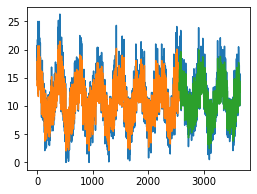

In [126]:
plt.figure(figsize=(4,3))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show() #